In [2]:
using Revise
includet("resolution/undirected/compact_undir.jl")
includet("utils/visu.jl")

In [7]:
instance = get_instance_1vn_from_folder("instances/undirected/tests/1120/1")

S_network dir created


Instance_Undir_VNE_1s(MetaGraph_s4_2, MetaGraph_trucito, MetaGraph_trucito_dir)

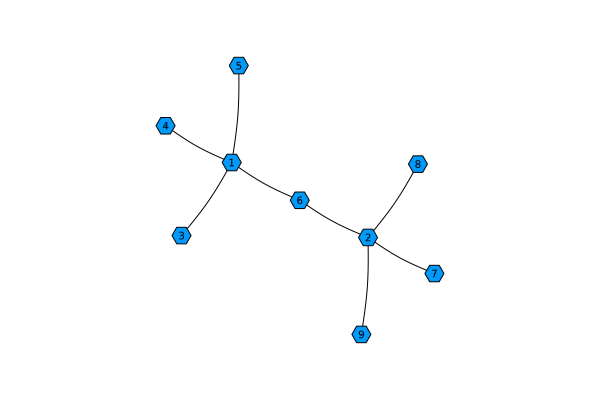

In [25]:
visu_graph(instance.v_network)

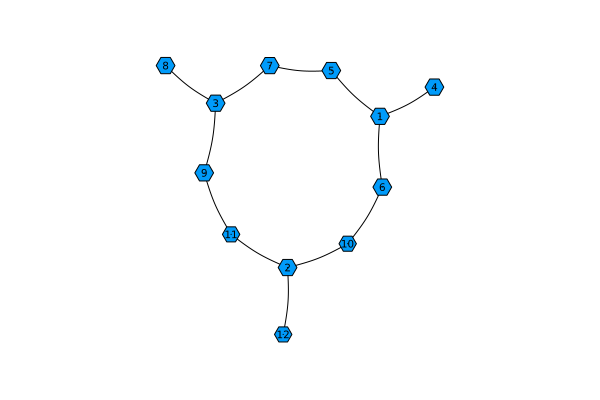

In [26]:
visu_graph(instance.s_network)

In [22]:
v_network = instance.v_network
s_network_dir = instance.s_network_dir


model = Model(CPLEX.Optimizer)
set_up_problem_undir_1vn_1t1(instance, model)

relax_integrality(model)
print("Starting solving... ")
optimize!(model)

x_values = value.(model[:x])
y_values = value.(model[:y])

println("Node placement:")
for v_node in vertices(v_network)
    println("For $(v_node):")
    for s_node in vertices(s_network_dir)
        if x_values[v_node, s_node] > 0.001
            println("      On $(s_node): $(x_values[v_node, s_node])")
        end
    end
end
println("\nEdge routing:")
for v_edge in edges(v_network)
    println("Routing of $v_edge : ")
    for s_edge in edges(s_network_dir)
        if y_values[v_edge, s_edge] > 0.001
            println("      On $(s_edge): $(y_values[v_edge, s_edge])")
        end
    end
    print("\n")
end


Starting solving... CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
Tried aggregator 1 time.
Reduced LP has 225 rows, 300 columns, and 1272 nonzeros.
Presolve time = 0.00 sec. (0.35 ticks)
Symmetry aggregator did 485 additional substitutions.
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =             0.000000

Dual crossover.
  Dual:  Fixing 25 variables.
       24 DMoves:  Infeasibility  0.00000000e+00  Objective  8.00000000e+00
        0 DMoves:  Infeasibility  0.00000000e+00  Objective  8.00000000e+00
  Dual:  Pushed 0, exchanged 25.
  Primal:  Fixing 57 variables.
       56 PMoves:  Infeasibility  1.20736754e-15  Objective  8.00000000e+00
        0 PMoves:  Infeasibility  1.53523028e-15  Objective  8.00000000e+00
  Primal:  Pushed 8, exchanged 49.
Node placement:
For 1:


      On 1: 0.16326530612244916
      On 2: 0.16666666666666638
      On 3: 0.17006802721088415
      On 5: 0.06530612244897968
      On 6: 0.03877551020408168
      On 9: 0.12925170068027225
      On 10: 0.1816326530612245
      On 11: 0.08503401360544226
For 2:
      On 1: 0.17006802721088413
      On 2: 0.16666666666666693
      On 3: 0.16326530612244916
      On 5: 0.06530612244897968
      On 6: 0.14081632653061218
      On 7: 0.16326530612244916
      On 9: 0.027210884353741277
      On 10: 0.011564625850340269
      On 11: 0.09183673469387726
For 3:
      On 1: 0.10408163265306136
      On 2: 0.2666666666666668
      On 3: 0.12925170068027225
      On 6: 0.16326530612244916
      On 7: 0.17006802721088415
      On 11: 0.16666666666666635
For 4:
      On 1: 0.10408163265306136
      On 3: 0.12925170068027225
      On 5: 0.03945578231292496
      On 6: 0.3054421768707487
      On 7: 0.17006802721088415
      On 9: 0.08503401360544226
      On 10: 0.16666666666666638
For 5:
      

In [33]:
model = Model(CPLEX.Optimizer)
set_up_problem_undir_1vn_1t1(instance, model)
#optimize!(problem.model)



# star stuff
# Get a list of nodes and their degrees
v_network = instance.v_network
node_degrees = [(v, degree(v_network, v)) for v in vertices(v_network)]

# Sort nodes by degree in descending order and take the top five
nb_v_node = 2
top_five_nodes = sort(node_degrees, by=x -> -x[2])[1:nb_v_node]


close_edges = []
for s_node in vertices(s_network_dir)
    edges_in_distance = edges_within_hop(s_network_dir, s_node)
    #println("Edge close to $s_node : $edges_in_distance")
    push!(close_edges, edges_in_distance)
end

nb_cons = 0
for (v_node, v_deg) in top_five_nodes
    v_edges_incident = [get_edge(v_network, v_node, neighbor) for neighbor in neighbors(v_network, v_node)]
    for s_node in vertices(s_network_dir)
        s_deg = degree(instance.s_network, s_node) 
        if s_deg < v_deg

            # Here we need to be extra careful about the pseudo orientation of the virtual network
            trucmuche = @expression(model, 0.)
            for v_edge in v_edges_incident
                if src(v_edge) == v_node
                    trucmuche += sum(model[:y][v_edge, s_edge]  for s_edge in close_edges[s_node])
                else
                    trucmuche += sum(model[:y][v_network, v_edge, get_edge(s_network_dir, dst(s_edge), src(s_edge))]  for s_edge in close_edges[s_node])
                end
            end
            cons = @constraint(model, 
                trucmuche >= (v_deg - s_deg) * model[:x][v_node, s_node]
            )

            nb_cons += 1
            #println("Wow look at this constraint: $cons")

        end
    end
end

println("\nWe have added $nb_cons star cuts")




We have added 24 star cuts
CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
Tried aggregator 1 time.
Reduced LP has 249 rows, 300 columns, and 1728 nonzeros.
Presolve time = 0.00 sec. (0.43 ticks)
Symmetry aggregator did 506 additional substitutions.
Initializing dual steep norms . . .

Iteration log . . .
Iteration:     1   Dual objective     =             0.000000

Dual crossover.
  Dual:  Fixing 26 variables.
       25 DMoves:  Infeasibility  0.00000000e+00  Objective  8.00000000e+00
        0 DMoves:  Infeasibility  0.00000000e+00  Objective  8.00000000e+00
  Dual:  Pushed 0, exchanged 26.
  Primal:  Fixing 50 variables.
       49 PMoves:  Infeasibility  5.13478149e-15  Objective  8.00000000e+00
        0 PMoves:  Infeasibility  3.01147995e-15  Objective  8.00000000e+00
  Primal:  Pushed 16, exchanged 34.
Node placement:
   Node 1:
       1 : 0.26974307177577167
       2 : 0.21324411337668087
       3 : 0.23129852913326174
     

In [8]:
# star stuff
# Get a list of nodes and their degrees
v_network = instance.v_network
node_degrees = [(v, degree(v_network, v)) for v in vertices(v_network)]

# Sort nodes by degree in descending order and take the top five
nb_v_node = 2
top_five_nodes = sort(node_degrees, by=x -> -x[2])[1:nb_v_node]

println("Top nodes: $(top_five_nodes)")

Top nodes: [(1, 4), (2, 4)]
